In [1]:
import numpy as np
import tensorflow as tf
import etp as etp
import calculate_virtual_coordinates as cvc
import matplotlib.pyplot as plt

from random import seed
from random import randint
seed(23)

C = 5 # maximum number of anchors
H = 500 # size of hidden filters
F = 2 # Final dimension of coordinates
random_seed = 23
radius = 1 # extent of possible communication
MAX_NODES = 10
learning_rate = 0.7
epochs = 1000
display_cost_period = 200

In [2]:
def plot_learning(cost_history):
    plt.plot(cost_history)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve')
    plt.show()

In [3]:
g = tf.Graph()

with g.as_default():
    tf.set_random_seed(random_seed)
    W_0 = tf.Variable(tf.truncated_normal(shape=(C, H),
                                      mean=0.0,
                                      stddev=0.1,
                                      dtype=tf.float32,
                                      seed=random_seed))
    
    W_1 = tf.Variable(tf.truncated_normal(shape=(H, F),
                                  mean=0.0,
                                  stddev=0.1,
                                  dtype=tf.float32,
                                  seed=random_seed))
    

    input_layer = tf.placeholder(tf.float32, [None, C], # INPUT: num_of_nodes X VC_values
                                 name='input')
    
    physical_coordinates = tf.placeholder(tf.float32, [None, F], # INPUT: num_of_nodes X geographic_coordinates
                                 name='phy_coord')
    
    adj = tf.placeholder(tf.float32, [None, None], # INPUT: num_of_nodes X num_of_nodes
                                 name='adj')
    
    A_caret = tf.placeholder(tf.float32, [None, None], # INPUT: num_of_nodes X num_of_nodes
                                 name='A_caret')

    
    out_1 = tf.matmul(tf.matmul(A_caret, input_layer), W_0)
    out_2 = tf.matmul(tf.matmul(A_caret, out_1), W_1)
    
#     curr_etp = etp.get_best_etp(out_2, physical_coordinates)
    
    
#     cost = etp.get_best_etp(out_2, physical_coordinates)
#     cost = etp.get_best_etp(out_2, physical_coordinates)
    
    cost = tf.losses.mean_squared_error(out_2, physical_coordinates)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

    saver = tf.train.Saver()



 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


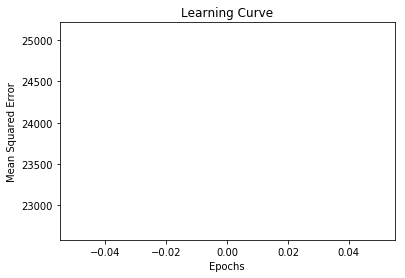

Epoch: 0	 cost: 23898.689453125	 ETP: 0.0
Epoch: 1	 cost: 0.6836225390434265	 ETP: 0.0
Epoch: 2	 cost: 83915.796875	 ETP: 0.0
Model saved in path: ~./model_h_1_g_1000.ckpt


In [4]:

cost_history = []
etp_history = []
with tf.Session(graph=g) as sess:
    # `sess.graph` provides access to the graph used in a `tf.Session`.
    writer = tf.summary.FileWriter("/tmp/log/...", sess.graph)

    # Perform your computation...
    for i in range(epochs):
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
        phy_coord, inps = cvc.get_VC(randint(6, MAX_NODES))
        adj_matrix = cvc.get_adj(phy_coord)
        A_caret_matrix = cvc.normalize_adj(adj_matrix + np.eye(adj_matrix.shape[0]))



        curr_cost, curr_out = sess.run([cost, out_2], feed_dict={input_layer: inps,
                                        physical_coordinates: phy_coord,
                                        adj: adj_matrix,
                                        A_caret: A_caret_matrix})
        curr_etp = etp.get_best_etp(curr_out, phy_coord)

        etp_history.append(curr_etp)


        cost_history.append(curr_cost)
        if not i%display_cost_period:
            plot_learning(cost_history)

        print('Epoch: {}\t cost: {}\t ETP: {}'.format(i, curr_cost, curr_etp.eval()))
        
    save_path = saver.save(sess, "~./model_h_1_g_1000.ckpt")
    print("Model saved in path: %s" % save_path)






    writer.close()


In [ ]:
plot_learning(cost_history)